# Import the necessary libraries

In [ ]:
!pip install simplejson
!pip install pyenchant
!apt-get install libenchant-dev


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant-dev is already the newest version (1.6.0-11.3build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
# Import the necessary libraries
import re
import gzip
import nltk
import shutil
import string
import joblib  
import enchant
import simplejson
import numpy as np
import pandas as pd
import pickle as pkl
import urllib.request
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Train Data

In [ ]:
# Set the URL of the file to download
url = "http://snap.stanford.edu/data/amazon/Electronics.txt.gz"

# Set the local file path to save the downloaded file
local_file_path = "/content/Electronics.txt.gz"

# Download the file from the URL and save it to the local file path
with urllib.request.urlopen(url) as response, open(local_file_path, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)


In [ ]:
with gzip.open('/content/Electronics.txt.gz', 'rt') as file:
    lines = file.readlines()

In [ ]:
lines

['product/productId: B0000630MQ\n',
 'product/title: Kodak Max K2000 Battery Charger with 4 NiMH AA Batteries\n',
 'product/price: unknown\n',
 'review/userId: A2F6FARSB1VL6Q\n',
 'review/profileName: "frumpy16"\n',
 'review/helpfulness: 2/2\n',
 'review/score: 5.0\n',
 'review/time: 1072915200\n',
 'review/summary: Great charger\n',
 'review/text: I recently bought this charger kit from Amazon and I am quite happy with my purchase. The folding plug is nice for storage. The included 1850 mAh batteries last for a long time in my Nikon Coolpix 2100. One of the best features of the charger is that each battery is charged separately (as opposed to in pairs) so that each battery gets just the right amount of charge. The short 3 hour charge time is great as well. The batteries do not get overly warm while charging either.Overall, this is a good charger for a good price. If you have a high drain device, the Kodak K2000 should keep you playing for a long time.\n',
 '\n',
 'product/productId: B

In [ ]:
data = [{}]
for line in lines:
    if line.startswith('product/') or line.startswith('review/'):
        key, value = line.strip().split(':', 1)  # split on the first colon only
        data[-1][key] = value.strip()
    else:
        data.append({})

In [ ]:
df = pd.DataFrame(data)

# Pre-Process Train Data

In [ ]:
Creative_products = df[df["product/title"].str.startswith("Creative", na=False)]
Creative_products

product/productId                                      product/title  \
2248           B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
2249           B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
2250           B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
2251           B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
2252           B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
...                   ...                                                ...   
1230981        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
1230982        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
1230983        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
1230984        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
1230985        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   

        product/price   review/userId  \
2248          unknown         unknown   
2249          unknown         unknown   
2250          unknown  A2FNB8O12FDYUR   
2251          unknown         unknown   
2252          unknown  A2ACJ55JHHJ3FU   
...               ...             ...   
1230981       unknown  A1CQROQ19LL99T   
1230982       unknown   A7EJERNB7IK3Z   
1230983       unknown  A2ABRNDQT9DCY1   
1230984       unknown  A3KW6MQX877MCS   
1230985       unknown  A3R3MAY1XHT362   

                                       review/profileName review/helpfulness  \
2248                                              unknown              13/13   
2249                                              unknown                9/9   
2250                            Eric Magnan "Techno Hero"                7/7   
2251                                              unknown               9/10   
2252                                         K. L. Woomer              18/23   
...                                                   ...                ...   
1230981                               doditika "doditika"                2/2   
1230982                                             CQ DX                1/1   
1230983                                   Humble Consumer                1/1   
1230984  Gale R. Stafford "Author of &#34;Getting Star...                1/1   
1230985                                           Mariusz                1/1   

        review/score review/time  \
2248             4.0  1071792000   
2249             4.0  1073692800   
2250             4.0  1078099200   
2251             1.0  1079568000   
2252             5.0  1071532800   
...              ...         ...   
1230981          3.0  1168300800   
1230982          5.0  1186185600   
1230983          3.0  1171152000   
1230984          4.0  1168560000   
1230985          3.0  1168560000   

                                            review/summary  \
2248                          Rhomba is fine little player   
2249                                            New to MP3   
2250                  Great Player/Radio/USB drive, but...   
2251                             Great at First, but......   
2252       Compare/Contrast MP3s: Flash Memory/Hard drives   
...                                                    ...   
1230981              Creative Zen V freezes up during play   
1230982  Amazing little bargain player with excellent s...   
1230983                                           MP3 User   
1230984                                         Good value   
1230985                       Still a big mystery to me...   

                                               review/text  
2248     I just received the Rhomba 128M MP3 player and...  
2249     Being new to MP3s I really had no idea what to...  
2250     I ordered this great little player as a birthd...  
2251     My daughter received this item as a Christmas ...  
2252     Okay. Here is a write up, that I did, on the c...  
...                                              

Data Selection of CREATIVE BRAND

In [ ]:
 
filtered_df = Creative_products.copy()
# re-index the filtered DataFrame and drop the old index
df=  filtered_df.reset_index(drop=True)
df

product/productId                                      product/title  \
0            B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
1            B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
2            B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
3            B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
4            B0000DFZ6J             Creative Labs Rhomba 256 MB MP3 Player   
...                 ...                                                ...   
15884        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
15885        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
15886        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
15887        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   
15888        B000BKBYYK  Creative Zen V 1 GB Portable Media Player (Bla...   

      product/price   review/userId  \
0           unknown         unknown   
1           unknown         unknown   
2           unknown  A2FNB8O12FDYUR   
3           unknown         unknown   
4           unknown  A2ACJ55JHHJ3FU   
...             ...             ...   
15884       unknown  A1CQROQ19LL99T   
15885       unknown   A7EJERNB7IK3Z   
15886       unknown  A2ABRNDQT9DCY1   
15887       unknown  A3KW6MQX877MCS   
15888       unknown  A3R3MAY1XHT362   

                                     review/profileName review/helpfulness  \
0                                               unknown              13/13   
1                                               unknown                9/9   
2                             Eric Magnan "Techno Hero"                7/7   
3                                               unknown               9/10   
4                                          K. L. Woomer              18/23   
...                                                 ...                ...   
15884                               doditika "doditika"                2/2   
15885                                             CQ DX                1/1   
15886                                   Humble Consumer                1/1   
15887  Gale R. Stafford "Author of &#34;Getting Star...                1/1   
15888                                           Mariusz                1/1   

      review/score review/time  \
0              4.0  1071792000   
1              4.0  1073692800   
2              4.0  1078099200   
3              1.0  1079568000   
4              5.0  1071532800   
...            ...         ...   
15884          3.0  1168300800   
15885          5.0  1186185600   
15886          3.0  1171152000   
15887          4.0  1168560000   
15888          3.0  1168560000   

                                          review/summary  \
0                           Rhomba is fine little player   
1                                             New to MP3   
2                   Great Player/Radio/USB drive, but...   
3                              Great at First, but......   
4        Compare/Contrast MP3s: Flash Memory/Hard drives   
...                                                  ...   
15884              Creative Zen V freezes up during play   
15885  Amazing little bargain player with excellent s...   
15886                                           MP3 User   
15887                                         Good value   
15888                       Still a big mystery to me...   

                                             review/text  
0      I just received the Rhomba 128M MP3 player and...  
1      Being new to MP3s I really had no idea what to...  
2      I ordered this great little player as a birthd...  
3      My daughter received this item as a Christmas ...  
4      Okay. Here is a write up, that I did, on the c...  
...                                                  ...  
15884  I liked the looks and colors for the Creative ...  
15885  For years as an audiophile, i've been blowing ...  
15

In [ ]:
df.isnull().sum()

product/productId     0
product/title         0
product/price         0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64

In [ ]:
# drop rows with null values
df = df.dropna()

In [ ]:
df.isnull().sum()

product/productId     0
product/title         0
product/price         0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64

In [ ]:
# Review=sampled_df.copy()
Review=df.copy()

In [ ]:
# remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness', 'review/time', 'review/summary']
Review = Review.drop(columns=columns_to_remove)

In [ ]:
Review

review/score                                        review/text
0              4.0  I just received the Rhomba 128M MP3 player and...
1              4.0  Being new to MP3s I really had no idea what to...
2              4.0  I ordered this great little player as a birthd...
3              1.0  My daughter received this item as a Christmas ...
4              5.0  Okay. Here is a write up, that I did, on the c...
...            ...                                                ...
15884          3.0  I liked the looks and colors for the Creative ...
15885          5.0  For years as an audiophile, i've been blowing ...
15886          3.0  I've owned Ipods and several other mp3 players...
15887          4.0  We got one of these recently and have been usi...
15888          3.0  Well, I wish it was as reliable as my old, bri...

[15889 rows x 2 columns]

In [ ]:
# replace decimal values in the review/score column with their corresponding integer values
# Review['User_Mlabel'] = Review['review/score'].replace({'5.0': 4, '4.0': 3, '3.0': 2, '2.0': 1, '1.0': 0}) # Used for Pre Trained Model
Review['User_label'] = Review['review/score'].replace({'5.0': 5, '4.0': 4, '3.0': 3, '2.0': 2, '1.0': 1})

In [ ]:
Review

review/score                                        review/text  \
0              4.0  I just received the Rhomba 128M MP3 player and...   
1              4.0  Being new to MP3s I really had no idea what to...   
2              4.0  I ordered this great little player as a birthd...   
3              1.0  My daughter received this item as a Christmas ...   
4              5.0  Okay. Here is a write up, that I did, on the c...   
...            ...                                                ...   
15884          3.0  I liked the looks and colors for the Creative ...   
15885          5.0  For years as an audiophile, i've been blowing ...   
15886          3.0  I've owned Ipods and several other mp3 players...   
15887          4.0  We got one of these recently and have been usi...   
15888          3.0  Well, I wish it was as reliable as my old, bri...   

       User_label  
0               4  
1               4  
2               4  
3               1  
4               5  
...           ...  
15884           3  
15885           5  
15886           3  
15887           4  
15888           3  

[15889 rows x 3 columns]

In [ ]:
df=Review.copy()

In [ ]:
# rename the review/score and review/text columns
df = df.rename(columns={'review/score': 'User_Rating', 'review/text': 'Review'})

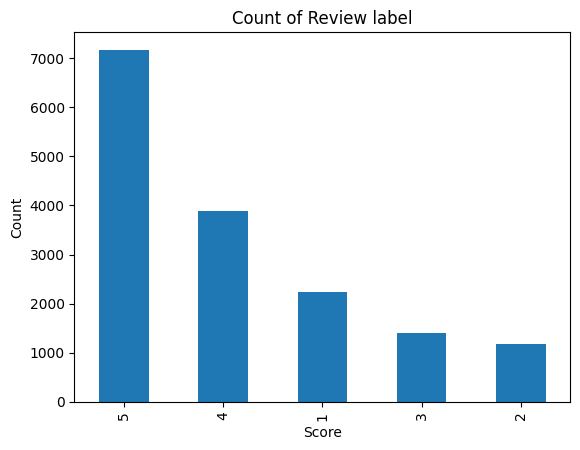

In [ ]:
# plot a bar chart of the count of each score value
df['User_label'].value_counts().plot.bar()
# set the title and axis labels
plt.title('Count of Review label')
plt.xlabel('Score')
plt.ylabel('Count')
# display the plot
plt.show()

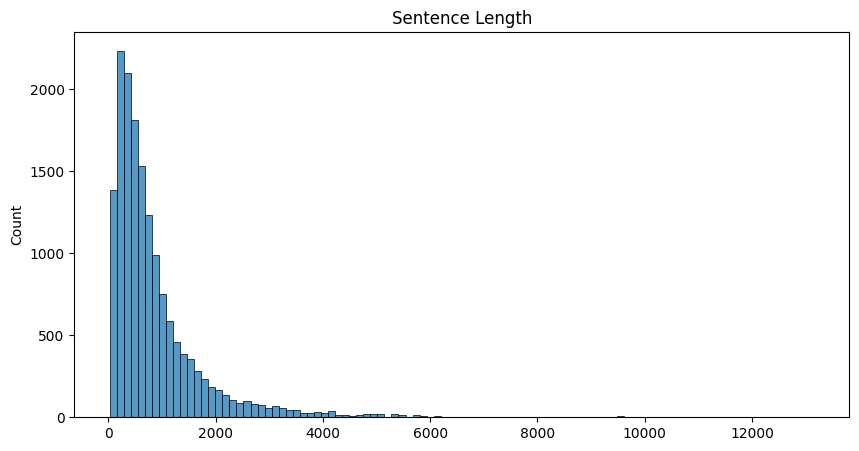

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.Review], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
Review_lengths = [len(s) for s in df['Review']]
df_Review_lengths = pd.DataFrame({'Review Length': Review_lengths})
df_Review_lengths

Review Length
0                624
1               1344
2                990
3                720
4               4121
...              ...
15884            647
15885           1500
15886            293
15887            462
15888            441

[15889 rows x 1 columns]

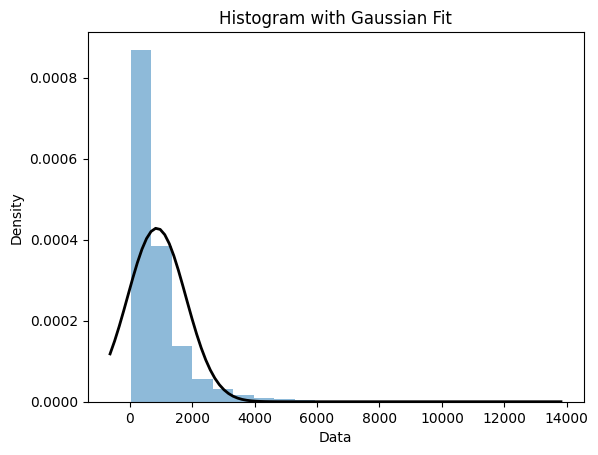

In [ ]:
# Generate random data
data = df_Review_lengths['Review Length']
# Fit a normal distribution to the data
mu, std = norm.fit(data)
# Create a histogram of the data
plt.hist(data, bins=20, density=True, alpha=0.5)
# Plot the probability density function (PDF) of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
# Add labels and title
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Histogram with Gaussian Fit')
# Show plot
plt.show()

In [ ]:

# Threshold_df=df.copy()

###    VADER (Valence Aware Dictionary and sEntiment Reasoner)  Score Calculation


In [ ]:
# Import SentimentIntensityAnalyzer and create an sid object
sid = SentimentIntensityAnalyzer()

In [ ]:
# Obtain the sid scores for your review
sid.polarity_scores(df['Review'][0])

{'neg': 0.038, 'neu': 0.877, 'pos': 0.085, 'compound': 0.5366}

In [ ]:
df['Vader_Scores'] = df['Review'].apply(lambda review: sid.polarity_scores(review))
df['Vader_Compound']  = df['Vader_Scores'].apply(lambda score_dict: score_dict['compound'])
df

User_Rating                                             Review  \
0             4.0  I just received the Rhomba 128M MP3 player and...   
1             4.0  Being new to MP3s I really had no idea what to...   
2             4.0  I ordered this great little player as a birthd...   
3             1.0  My daughter received this item as a Christmas ...   
4             5.0  Okay. Here is a write up, that I did, on the c...   
...           ...                                                ...   
15884         3.0  I liked the looks and colors for the Creative ...   
15885         5.0  For years as an audiophile, i've been blowing ...   
15886         3.0  I've owned Ipods and several other mp3 players...   
15887         4.0  We got one of these recently and have been usi...   
15888         3.0  Well, I wish it was as reliable as my old, bri...   

       User_label                                       Vader_Scores  \
0               4  {'neg': 0.038, 'neu': 0.877, 'pos': 0.085, 'co...   
1               4  {'neg': 0.04, 'neu': 0.742, 'pos': 0.218, 'com...   
2               4  {'neg': 0.084, 'neu': 0.713, 'pos': 0.203, 'co...   
3               1  {'neg': 0.011, 'neu': 0.884, 'pos': 0.104, 'co...   
4               5  {'neg': 0.047, 'neu': 0.892, 'pos': 0.061, 'co...   
...           ...                                                ...   
15884           3  {'neg': 0.041, 'neu': 0.851, 'pos': 0.109, 'co...   
15885           5  {'neg': 0.042, 'neu': 0.762, 'pos': 0.196, 'co...   
15886           3  {'neg': 0.073, 'neu': 0.818, 'pos': 0.109, 'co...   
15887           4  {'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...   
15888           3  {'neg': 0.087, 'neu': 0.675, 'pos': 0.238, 'co...   

       Vader_Compound  
0              0.5366  
1              0.9956  
2              0.9754  
3              0.8402  
4              0.9480  
...               ...  
15884          0.7380  
15885          0.9942  
15886          0.2960  
15887          0.8225  
15888          0.9387  

[15889 rows x 5 columns]

# Labelling Data considering  Class 0 as "Negative", Class 1 as "Neutral" and Class 2 as "Positive".

In [ ]:
# Used for 5 Star Classification for Pre Trained Model
# def assign_category_Machine(vader_score):
#     if vader_score < -0.6:
#         return 0
#     elif vader_score < -0.25:
#         return 1
#     elif vader_score < 0.25:
#         return 2
#     elif vader_score < 0.6:
#         return 3
#     else:
#         return 4

In [ ]:

def Vader_sentiment_label(vader_score):
    if vader_score < 0:
        return 0       # Negative
    elif vader_score < 0.25:
        return 1      # Neutral
    else:
        return 2     # Positive

In [ ]:

def User_Sentiment_Label_1(score):   # Based on customer Label
    if score < 2.5:  
        return 0     # 1 and 2 star >  class 0 Negative
    elif score < 4.5: 
        return 1     # 3 and 4 star >  class 1 Neutral
    else:              
        return 2    # 5 star >  class 2 Positive

In [ ]:

def User_Sentiment_Label_2(score):   # Based on customer Label
    if score < 2.5:  
        return 0     # 1 and 2 star > class 0 Negative
    elif score < 3.5: 
        return 1    # 3  star >  class 1  Neutral
    else:              
        return 2      #  4 & 5 star >  class 2 Positive

In [ ]:
 
df

User_Rating                                             Review  \
0             4.0  I just received the Rhomba 128M MP3 player and...   
1             4.0  Being new to MP3s I really had no idea what to...   
2             4.0  I ordered this great little player as a birthd...   
3             1.0  My daughter received this item as a Christmas ...   
4             5.0  Okay. Here is a write up, that I did, on the c...   
...           ...                                                ...   
15884         3.0  I liked the looks and colors for the Creative ...   
15885         5.0  For years as an audiophile, i've been blowing ...   
15886         3.0  I've owned Ipods and several other mp3 players...   
15887         4.0  We got one of these recently and have been usi...   
15888         3.0  Well, I wish it was as reliable as my old, bri...   

       User_label                                       Vader_Scores  \
0               4  {'neg': 0.038, 'neu': 0.877, 'pos': 0.085, 'co...   
1               4  {'neg': 0.04, 'neu': 0.742, 'pos': 0.218, 'com...   
2               4  {'neg': 0.084, 'neu': 0.713, 'pos': 0.203, 'co...   
3               1  {'neg': 0.011, 'neu': 0.884, 'pos': 0.104, 'co...   
4               5  {'neg': 0.047, 'neu': 0.892, 'pos': 0.061, 'co...   
...           ...                                                ...   
15884           3  {'neg': 0.041, 'neu': 0.851, 'pos': 0.109, 'co...   
15885           5  {'neg': 0.042, 'neu': 0.762, 'pos': 0.196, 'co...   
15886           3  {'neg': 0.073, 'neu': 0.818, 'pos': 0.109, 'co...   
15887           4  {'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...   
15888           3  {'neg': 0.087, 'neu': 0.675, 'pos': 0.238, 'co...   

       Vader_Compound  
0              0.5366  
1              0.9956  
2              0.9754  
3              0.8402  
4              0.9480  
...               ...  
15884          0.7380  
15885          0.9942  
15886          0.2960  
15887          0.8225  
15888          0.9387  

[15889 rows x 5 columns]

In [ ]:
df['Vader_sentiment_label'] = df['Vader_Compound'].apply(Vader_sentiment_label)
# df['Vader_Mlabel'] = df['Vader_Compound'].apply(assign_category_Machine)
df['User_Sentiment_Label_1'] = df['User_label'].apply(User_Sentiment_Label_1)
df['User_Sentiment_Label_2'] = df['User_label'].apply(User_Sentiment_Label_2)
df

User_Rating                                             Review  \
0             4.0  I just received the Rhomba 128M MP3 player and...   
1             4.0  Being new to MP3s I really had no idea what to...   
2             4.0  I ordered this great little player as a birthd...   
3             1.0  My daughter received this item as a Christmas ...   
4             5.0  Okay. Here is a write up, that I did, on the c...   
...           ...                                                ...   
15884         3.0  I liked the looks and colors for the Creative ...   
15885         5.0  For years as an audiophile, i've been blowing ...   
15886         3.0  I've owned Ipods and several other mp3 players...   
15887         4.0  We got one of these recently and have been usi...   
15888         3.0  Well, I wish it was as reliable as my old, bri...   

       User_label                                       Vader_Scores  \
0               4  {'neg': 0.038, 'neu': 0.877, 'pos': 0.085, 'co...   
1               4  {'neg': 0.04, 'neu': 0.742, 'pos': 0.218, 'com...   
2               4  {'neg': 0.084, 'neu': 0.713, 'pos': 0.203, 'co...   
3               1  {'neg': 0.011, 'neu': 0.884, 'pos': 0.104, 'co...   
4               5  {'neg': 0.047, 'neu': 0.892, 'pos': 0.061, 'co...   
...           ...                                                ...   
15884           3  {'neg': 0.041, 'neu': 0.851, 'pos': 0.109, 'co...   
15885           5  {'neg': 0.042, 'neu': 0.762, 'pos': 0.196, 'co...   
15886           3  {'neg': 0.073, 'neu': 0.818, 'pos': 0.109, 'co...   
15887           4  {'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...   
15888           3  {'neg': 0.087, 'neu': 0.675, 'pos': 0.238, 'co...   

       Vader_Compound  Vader_sentiment_label  User_Sentiment_Label_1  \
0              0.5366                      2                       1   
1              0.9956                      2                       1   
2              0.9754                      2                       1   
3              0.8402                      2                       0   
4              0.9480                      2                       2   
...               ...                    ...                     ...   
15884          0.7380                      2                       1   
15885          0.9942                      2                       2   
15886          0.2960                      2                       1   
15887          0.8225                      2                       1   
15888          0.9387                      2                       1   

       User_Sentiment_Label_2  
0                           2  
1                           2  
2                           2  
3                           0  
4                           2  
...                       ...  
15884                       1  
15885                       2  
15886                       1  
15887                       2  
15888                       1  

[15889 rows x 8 columns]

In [ ]:
from pandas.core.generic import DataFrameRenderer
# Count total occurrences of values in User_Mlabel column
user_mlabel_counts = df['User_label'].value_counts()
print(user_mlabel_counts)

# Count total unique values in Sentiment_Label column
sentiment_label_1_counts = df['User_Sentiment_Label_1'].value_counts()
print(sentiment_label_1_counts)

# Count total unique values in Sentiment_Label column
sentiment_label_2_counts = df['User_Sentiment_Label_2'].value_counts()
print(sentiment_label_2_counts)

# Count total unique values in Sentiment_Label column
vader_label_counts = df['Vader_sentiment_label'].value_counts()
print(vader_label_counts)

5    7170
4    3886
1    2243
3    1407
2    1183
Name: User_label, dtype: int64
2    7170
1    5293
0    3426
Name: User_Sentiment_Label_1, dtype: int64
2    11056
0     3426
1     1407
Name: User_Sentiment_Label_2, dtype: int64
2    13023
0     2227
1      639
Name: Vader_sentiment_label, dtype: int64


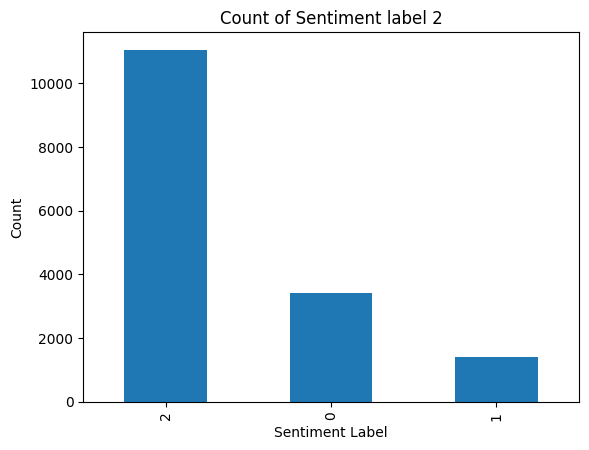

In [ ]:
# plot a bar chart of the count of each score value
df['User_Sentiment_Label_2'].value_counts().plot.bar()
# set the title and axis labels
plt.title('Count of Sentiment label 2')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
# display the plot
plt.show()

In [ ]:
print(df['Vader_sentiment_label'].dtypes)
print(df['User_Sentiment_Label_1'].dtypes)
print(df['User_Sentiment_Label_2'].dtypes)

int64
int64
int64


In [ ]:
# remove the specified columns
columns_to_remove = ['Vader_Compound','User_Rating', 'Vader_Scores' ]   
df = df.drop(columns=columns_to_remove)
df

Review  User_label  \
0      I just received the Rhomba 128M MP3 player and...           4   
1      Being new to MP3s I really had no idea what to...           4   
2      I ordered this great little player as a birthd...           4   
3      My daughter received this item as a Christmas ...           1   
4      Okay. Here is a write up, that I did, on the c...           5   
...                                                  ...         ...   
15884  I liked the looks and colors for the Creative ...           3   
15885  For years as an audiophile, i've been blowing ...           5   
15886  I've owned Ipods and several other mp3 players...           3   
15887  We got one of these recently and have been usi...           4   
15888  Well, I wish it was as reliable as my old, bri...           3   

       Vader_sentiment_label  User_Sentiment_Label_1  User_Sentiment_Label_2  
0                          2                       1                       2  
1                          2                       1                       2  
2                          2                       1                       2  
3                          2                       0                       0  
4                          2                       2                       2  
...                      ...                     ...                     ...  
15884                      2                       1                       1  
15885                      2                       2                       2  
15886                      2                       1                       1  
15887                      2                       1                       2  
15888                      2                       1                       1  

[15889 rows x 5 columns]

In [ ]:
# Define a function to preprocess the text data
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))   
    # Tokenize the text
    tokens = word_tokenize(text)  
    # Remove stopwords
    stopwords_list = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords_list]  
    # Check for misspelled words
    # english_dict = enchant.Dict("en_US")
    # tokens = [token for token in tokens if english_dict.check(token)]
    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  
    # Join the tokens back into text
    text = ' '.join(tokens)  
    return text

In [ ]:
# Apply the preprocess function to the text data
df['Review'] = df['Review'].apply(preprocess)


# Split Test Train Data

In [ ]:
# Split the data into training and testing sets with stratification
train_data, test_data = train_test_split(df, test_size=0.15, random_state= 17  )   

In [ ]:
X_train =  train_data['Review']
y_train = train_data['User_Sentiment_Label_2']  
X_test = test_data['Review']
y_test = test_data['User_Sentiment_Label_2']   

# Model Selection

# With GRID SEARCH CV

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from scipy.stats import randint as sp_randint

# # Define pipeline and parameter distributions for each classifier
# logistic_pipe = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("classifier", LogisticRegression())
# ])
# logistic_params = {
#     "tfidf__max_features": [1000, 5000, 10000, None],
#     "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
#     "classifier__penalty": ["l1", "l2"],
#     "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     "classifier__solver": ["newton-cg", "saga", "sag", "liblinear", "lbfgs"],
#     "classifier__multi_class": ['ovr', 'multinomial']
# }

# tree_pipe = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("classifier", DecisionTreeClassifier())
# ])
# tree_params = {
#     "tfidf__max_features": [1000, 5000, 10000, None],
#     "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
#     "classifier__max_depth": [None, 5, 10, 15, 20],
#     "classifier__min_samples_split": [2, 5, 10],
#     "classifier__min_samples_leaf": [1, 2, 4],
#     "classifier__criterion": ['gini', 'entropy']
# }

# forest_pipe = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("classifier", RandomForestClassifier())
# ])
# forest_params = {
#     "tfidf__max_features": [1000, 5000, 10000, None],
#     "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
#     "classifier__n_estimators": [100, 300, 500],
#     "classifier__max_features": ["sqrt", "log2"],
#     "classifier__max_depth": [None, 5, 10, 15, 20],
#     "classifier__min_samples_split": [2, 5, 10],
#     "classifier__min_samples_leaf": [1, 2, 4],
#     "classifier__criterion": ['gini', 'entropy', 'auto']
# }

# # Define parameter distribution list for GridSearchCV
# param_dists = [
#     (logistic_pipe, logistic_params),
#     (tree_pipe, tree_params),
#     (forest_pipe, forest_params)
# ]

# # Loop through each classifier, perform grid search and print best parameters
# best_model = None
# best_score = 0.0
# for pipe, params in param_dists:
#     grid_search = GridSearchCV(pipe, params, cv=5, n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     score = grid_search.best_score_
#     if score > best_score:
#         best_model = grid_search.best_estimator_
#         best_score = score
#     print(f"Best parameters for {pipe.named_steps['classifier']}:\n{grid_search.best_params_}\n")
    
# # Print best model and its score
# print("Best model overall:")
# print(best_model)
# print(f"Accuracy score: {best_score:.3f}")


# With RANDOM SEARCH CV

In [ ]:

# Define pipeline and parameter distributions for each classifier
logistic_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", LogisticRegression())
])
logistic_params = {
    "tfidf__max_features": sp_randint(100, 1001), #716 993
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)], #(1,2)
    "classifier__penalty": ["l1", "l2"], #l2
    "classifier__C": np.logspace(0, 4, 100), # 3-4.43062
    "classifier__solver": ["newton-cg", "saga", "sag", "liblinear", "lbfgs"], # saga
    "classifier__multi_class": ['ovr', 'multinomial'] #multinomial
}

tree_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", DecisionTreeClassifier())
])
tree_params = {
    "tfidf__max_features": sp_randint(100, 1001), # 656
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)], #2,2
    "classifier__max_depth": sp_randint(1, 20),  #14 2
    "classifier__min_samples_split": sp_randint(2, 11), #7 6
    "classifier__criterion": ['gini', 'entropy']  # 'gini'
}

forest_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", RandomForestClassifier())
])
forest_params = {
    "tfidf__max_features": sp_randint(100, 1001), #829
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)], #1,2
    "classifier__n_estimators": sp_randint(10, 1001), #91
    "classifier__max_features": ["sqrt", "log2"], # sqrt
    "classifier__max_depth": sp_randint(1, 31),  #16 3
    "classifier__min_samples_split": sp_randint(2, 11), #5 9
    "classifier__min_samples_leaf": sp_randint(1, 6), #2,1
    "classifier__max_leaf_nodes": sp_randint(2, 11), # 4 
    "classifier__criterion": ['gini', 'entropy']  # entropy
}

# Define parameter distribution list for RandomizedSearchCV
param_dists = [
    (logistic_pipe, logistic_params),
    (tree_pipe, tree_params),
    (forest_pipe, forest_params)
]

best_model = None
best_score = 0.0
for pipe, params in param_dists:
    random_search = RandomizedSearchCV(pipe, params, n_iter=50, cv=5, n_jobs=-1)
    random_search.fit(X_train, y_train)
    score = random_search.best_score_
    if score > best_score:
        best_model = random_search.best_estimator_
        best_score = score
    print(f"Best parameters for {pipe.named_steps['classifier']}:\n{random_search.best_params_}")
    print(f"Accuracy score for {pipe.named_steps['classifier']}:")
    print(random_search.cv_results_['mean_test_score'])
    print("\n")

# Print best model and its score
print("Best model overall:")
print(best_model)
print(f"Accuracy score: {best_score:.3f}")

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

Best parameters for LogisticRegression():
{'classifier__C': 4.862601580065355, 'classifier__multi_class': 'ovr', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'tfidf__max_features': 720, 'tfidf__ngram_range': (1, 1)}
Accuracy score for LogisticRegression():
[       nan 0.77734173 0.80533136 0.81725287 0.80466494        nan
        nan        nan        nan        nan        nan 0.80599778
 0.76342096 0.81251388 0.80836727 0.81177342 0.78215476 0.81599408
 0.80599778        nan 0.8144391         nan        nan        nan
        nan        nan        nan        nan 0.81125509 0.80770085
 0.77326916 0.81288412 0.79814883 0.79659385        nan        nan
 0.77297297 0.81266198 0.74335431 0.80725657        nan 0.76653091
 0.80836727 0.81266198 0.81414291 0.80851536 0.80518327 0.77304702
        nan 0.76630877]


Best parameters for DecisionTreeClassifier():
{'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_split': 8, 'tfidf__max_features':

namaj porlam

In [ ]:
logistic_pipe

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

## Saving the Best  Model  

In [ ]:
# Save the best model
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

................................................................................